In [1]:
import lightgbm as lgb
import pandas as pd 
import sqlite3
import numpy as np
from prophet import Prophet
from tqdm.notebook import tqdm
from sklearn.model_selection import KFold
from datetime import datetime as dt

In [2]:
pd.options.display.max_columns = 50

def create_connection(db_file):
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        print(sqlite3.version)
    except Error as e:
        print(e)
    return conn

database = r"pythonsqlite.db"
conn = create_connection(database)

2.6.0


## Подготовка ежедневных данных для модели

Согласно результатам работы в пункте 2

In [3]:
query = """
SELECT 
    PRICE_DATE, 
    d.FIGI,
    CLOSE_PRICE,
    OPEN_PRICE,
    HIGH_PRICE,
    LOW_PRICE,
    CURRENCY,
    NAME,
    TICKER,
    ISIN
FROM stocks_daily d
LEFT JOIN 
    stocks i ON i.FIGI = d.FIGI
"""
stocks_daily_df_1 = pd.read_sql(sql=query, con=conn)

query = """ SELECT * FROM stocks_yahoo """
stocks_yahoo_df_1 = pd.read_sql(sql=query, con=conn)

stocks_daily_df_1["PRICE_DATE"] = pd.to_datetime(stocks_daily_df_1["PRICE_DATE"])
stocks_daily_df_1.loc[:, "WEEKDAY"] = stocks_daily_df_1.loc[:, "PRICE_DATE"].dt.weekday
stocks_daily_df_1.loc[:, "MONTH"] = stocks_daily_df_1.loc[:, "PRICE_DATE"].dt.month
stocks_daily_df_1.loc[:, "DAY"] = stocks_daily_df_1.loc[:, "PRICE_DATE"].dt.day

stocks_yahoo_df_1["SYMBOL"] = stocks_yahoo_df_1["SYMBOL"].str.replace("\.ME", "")
stocks_yahoo_df_1["SYMBOL"] = stocks_yahoo_df_1["SYMBOL"].str.replace("\.DE", "@DE")

stocks_daily_df_1 = stocks_daily_df_1.merge(
    stocks_yahoo_df_1, how="inner", left_on="TICKER", right_on="SYMBOL"
)

stocks_daily_df_1 = stocks_daily_df_1[
    ~(
        (stocks_daily_df_1["MARKET"] == "us_market")
        & (stocks_daily_df_1["CURRENCY"] == "RUB")
    )
].reset_index(drop=True)

stocks_daily_df_1 = stocks_daily_df_1[stocks_daily_df_1["WEEKDAY"] != 5].reset_index(
    drop=True
)

val_counts_1 = stocks_daily_df_1["TICKER"].value_counts()
stocks_daily_df_1 = stocks_daily_df_1[
    stocks_daily_df_1["TICKER"].isin(val_counts_1[val_counts_1 > 100].index)
].reset_index(drop=True)

stocks_daily_df_1["PRICE_DATE"] = stocks_daily_df_1["PRICE_DATE"].dt.date


<ipython-input-3-c3cede68b862>:27: FutureWarning: The default value of regex will change from True to False in a future version.
  stocks_yahoo_df_1["SYMBOL"] = stocks_yahoo_df_1["SYMBOL"].str.replace("\.ME", "")
<ipython-input-3-c3cede68b862>:28: FutureWarning: The default value of regex will change from True to False in a future version.
  stocks_yahoo_df_1["SYMBOL"] = stocks_yahoo_df_1["SYMBOL"].str.replace("\.DE", "@DE")


In [4]:
df_1 = stocks_daily_df_1.copy()
df_1.drop(
    columns=[
        "FIGI",
        "CURRENCY",
        "ISIN",
        "SYMBOL",
        "LONG_BUSINESS_SUMMARY",
        "CITY",
        "PRICE_HINT",
        "FORWARD_EPS",
        'MONTH',
        'NAME'
    ], inplace=True
)

### FBProphet

Ранее, в части 2 уже было проговорено, что относится к данным как ко временному ряду не выглядит перспективным. Однако, так как изначально задумавалась возможность использования методов по работе с временными рядами, то для успокения души была попытка использовать один из инструментов работы с ними - FBProphet, однако как и ожидалось результат выглядит не особо. 

Так как FBProphet строится на идее непараметрической регрессии использующей тренды и сезонности от времени, которые, как было рассмотрено в части 2, не выглядят значимыми в текущих данных, то ее результативность оставляет желать лучшего.

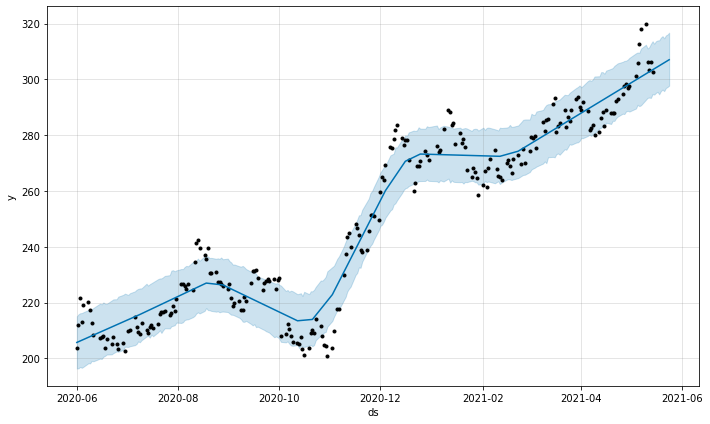

In [5]:
ticker = 'SBER'
buf_df = df_1[(df_1['TICKER']==ticker)][['PRICE_DATE','CLOSE_PRICE']]
buf_df.columns = ['ds', 'y']

m = Prophet(weekly_seasonality=False, yearly_seasonality=False, daily_seasonality=False)
# m.add_seasonality(name='weekly_custom', period=5, fourier_order=3)
m.fit(buf_df.iloc[:-10])
future = m.make_future_dataframe(periods=10)
forecast = m.predict(future)
fig1 = m.plot(forecast)


### LightGBM

Библиотека для градиентных бустингов. Выбрал ее, ибо в среднем быстрее обучается чем CatBoost, а средняя точность в сравнении с CatBoost для первоначальных изысканий уместна

Так как мастштаб цены,  на самом деле не важен, имеет смысл использовать данные по предыдущей динамике

In [7]:
target_comparsion = 'CLOSE_PRICE'
prices_columns = ["CLOSE_PRICE", "OPEN_PRICE", "HIGH_PRICE", "LOW_PRICE"]
for field in prices_columns:
    for i in range(1, 21):
        df_1["CHANGE_{0}D_".format(i) + field] = (
                df_1[target_comparsion] / df_1.groupby("TICKER")["CLOSE_PRICE"].shift(i)
            )- 1

df_1['TARGET'] = (
    df_1.groupby("TICKER")["CLOSE_PRICE"].shift(-1)/df_1[target_comparsion]
) - 1

Вместо использования категорий, будут использоваться категориальные статистики, с пересечением категорий "День недели", 'Сектор', 'Рынок (амер, рус, нем)' на данных за последние две недели (не включая текущую дату)

In [8]:
def groupby_func_1(x, cols):
    if x["PRICE_DATE"].nunique() == 1:
        date = x["PRICE_DATE"].unique()[0]
        z = df_1[
            (df_1["PRICE_DATE"] > x["PRICE_DATE"].unique()[0] - pd.Timedelta(10, "D"))&\
                 (df_1["PRICE_DATE"] <= x["PRICE_DATE"].unique()[0])
            ]
        for col in cols:
            if col == "PRICE_DATE":
                continue
            z = z[(z[col] == x[col].unique()[0])]
        return z[ "TARGET"].mean()
    else:
        return x["TARGET"].mean()


def add_agg(merged_df, gr_cols, new_col_name):

    agg1 = df_1.groupby(gr_cols).apply(groupby_func_1, gr_cols).reset_index()
    cols2 = gr_cols.copy()
    cols2.append(new_col_name)
    agg1.columns = cols2
    merged_df = pd.merge(df_1, agg1, how="left", left_on=gr_cols, right_on=gr_cols)
    return merged_df


In [9]:
df_2 = add_agg(df_1, ['PRICE_DATE', 'WEEKDAY','SECTOR', 'MARKET'], 'twsm')

In [10]:
train_target = df_2.loc[df_2['PRICE_DATE'] < dt.strptime('20210515' , '%Y%m%d').date()]['TARGET']
test_target = df_2.loc[df_2['PRICE_DATE'] >= dt.strptime('20210515' , '%Y%m%d').date()]['TARGET']

In [11]:
df_2.drop(columns = 'TARGET', inplace = True)

In [12]:
params = {
    'nthread': 8,
    'max_depth': -1,
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression_l1',
    'metric': 'mse', 
    'num_leaves': 31,
    'learning_rate': 0.03,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l1': 0.05,
    'lambda_l2': 0.05,
    'verbose': -1
}

In [13]:
def train_lgbm(all_x, all_y, test_x):

    oof_preds = np.zeros([all_y.shape[0]])
    sub_preds = np.zeros([test_x.shape[0]])

    feature_importance_df = pd.DataFrame()

    folds = KFold(n_splits=num_folds, shuffle=True, random_state=2021)

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(all_x)):
        train_x, train_y = all_x[train_idx], all_y[train_idx]
        valid_x, valid_y = all_x[valid_idx], all_y[valid_idx]
        lgb_train = lgb.Dataset(train_x, train_y)
        lgb_valid = lgb.Dataset(valid_x, valid_y)

        # train
        gbm = lgb.train(
            params,
            lgb_train,
            1000,
            valid_sets=[lgb_train, lgb_valid],
            early_stopping_rounds=100,
            verbose_eval=100,
        )
        oof_preds[valid_idx] = gbm.predict(valid_x, num_iteration=gbm.best_iteration)
        sub_preds[:] += (
            gbm.predict(test_x, num_iteration=gbm.best_iteration) / folds.n_splits
        )
        valid_idx += 1
        importance_df = pd.DataFrame()
        importance_df["feature"] = used_columns
        importance_df["importance"] = gbm.feature_importance()
        importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat(
            [feature_importance_df, importance_df], axis=0
        )
        return oof_preds, sub_preds, feature_importance_df


In [14]:
num_folds = 5
columns_to_drop = [
    "CLOSE_PRICE",
    "OPEN_PRICE",
    "HIGH_PRICE",
    "LOW_PRICE",
    "PRICE_DATE",
    "INDUSTRY",
    "COUNTRY",
    "TICKER",
    "WEEKDAY",
    "SECTOR",
    "MARKET",
    'DAY',
]
test_x = (
    df_2.loc[df_2["PRICE_DATE"] >= dt.strptime("20210515", "%Y%m%d").date()]
    .drop(columns=columns_to_drop)
    .values
)
all_x = (
    df_2.loc[df_2["PRICE_DATE"] < dt.strptime("20210515", "%Y%m%d").date()]
    .drop(columns=columns_to_drop)
    .values
)
all_y = train_target.values

used_columns = df_2.drop(columns=columns_to_drop).columns

_, sub_preds, feature_importance_df = train_lgbm(all_x, all_y, test_x)


Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000687613	valid_1's l2: 0.000687869
[200]	training's l2: 0.000670812	valid_1's l2: 0.000673641
[300]	training's l2: 0.000661631	valid_1's l2: 0.000666735
[400]	training's l2: 0.000655862	valid_1's l2: 0.000663743
[500]	training's l2: 0.000651047	valid_1's l2: 0.000661185
[600]	training's l2: 0.000646963	valid_1's l2: 0.000659309
[700]	training's l2: 0.000642623	valid_1's l2: 0.000657527
[800]	training's l2: 0.000639011	valid_1's l2: 0.00065634
[900]	training's l2: 0.000635688	valid_1's l2: 0.000655102
[1000]	training's l2: 0.000632554	valid_1's l2: 0.000654171
Did not meet early stopping. Best iteration is:
[1000]	training's l2: 0.000632554	valid_1's l2: 0.000654171


In [15]:
feature_importance_df.sort_values('importance').tail(20)

,feature,importance,fold
28,CHANGE_18D_CLOSE_PRICE,674,1
26,CHANGE_16D_CLOSE_PRICE,676,1
7,NET_INCOME_TO_COMMON,682,1
8,ENTERPRISE_TO_REVENUE,734,1
16,CHANGE_6D_CLOSE_PRICE,761,1
21,CHANGE_11D_CLOSE_PRICE,822,1
30,CHANGE_20D_CLOSE_PRICE,832,1
18,CHANGE_8D_CLOSE_PRICE,836,1
4,FORWARD_PE,856,1
0,FULL_TIME_EMPLOYEES,868,1


In [16]:
result = pd.concat(
    [
        df_2.loc[df_2["PRICE_DATE"] >= dt.strptime("20210515", "%Y%m%d").date()],
        test_target,
        pd.Series(sub_preds, index=test_target.index, name="PREDICT"),
    ],
    axis=1,
)


In [17]:
result['ERROR'] = result['PREDICT'] - result['TARGET'] 
result['ABSERROR'] = abs(result['TARGET'] - result['PREDICT'])

In [18]:
result.groupby('SECTOR')['ERROR'].agg(['mean','median', 'std', 'min', 'max', 'count']).sort_values('median')

,mean,median,std,min,max,count
SECTOR,,,,,,
Technology,-0.004905,-0.002651,0.016756,-0.175014,0.131798,2099
Real Estate,-0.003109,-0.002229,0.011700,-0.053713,0.039599,540
Communication Services,-0.003401,-0.001868,0.018778,-0.086099,0.107590,812
Healthcare,-0.002287,-0.001048,0.024223,-0.238917,0.393020,2103
Financial Services,-0.000828,-0.000993,0.013119,-0.086828,0.050365,1321
Industrials,-0.000463,-0.000477,0.017413,-0.278991,0.150001,1980
Utilities,-0.000059,-0.000144,0.012579,-0.111387,0.057276,611
Consumer Defensive,-0.000202,0.000301,0.018202,-0.181259,0.172214,845
Consumer Cyclical,-0.000248,0.000562,0.021199,-0.167680,0.125051,1852


In [19]:
result.groupby('MARKET')['ERROR'].agg(['mean','median', 'std', 'min', 'max', 'count']).sort_values('median')

,mean,median,std,min,max,count
MARKET,,,,,,
de_market,-0.000455,-0.001473,0.012620,-0.029722,0.050124,80
us_market,-0.001575,-0.000808,0.019036,-0.278991,0.393020,12300
ru_market,-0.000828,0.000088,0.017822,-0.167791,0.091399,1259


In [20]:
result.groupby('WEEKDAY')['ERROR'].agg(['mean','median', 'std', 'min', 'max', 'count']).sort_values('median')

,mean,median,std,min,max,count
WEEKDAY,,,,,,
4,-0.005370,-0.004385,0.018470,-0.278991,0.172214,1526
2,-0.005870,-0.004221,0.020200,-0.164350,0.374926,3045
1,-0.002431,-0.001273,0.021254,-0.238917,0.393020,3046
3,0.000125,0.000088,0.014412,-0.175014,0.102612,3045
0,0.004184,0.004623,0.017343,-0.181259,0.150001,3035


### Использование результатов модели
Воспользуемся идеей - рынок всегда растет, и возможно пытаться переиграть его опыта пока нет. 
Однако если взять компании, прогноз по которым у модели делать получается лучше всего и при этом, прогноз по ними положительнее. 

При этом, каждая компания будет лучше непосредственно в своем секторе, то есть портфель будет диферсифицирован относительно секторов промышленности.

In [21]:
sector_tickers = result.groupby("SECTOR")["TICKER"].unique().to_dict()
for i in range(1, 4):
    filt_date_1 = (result["PRICE_DATE"] >= dt.strptime("20210515", "%Y%m%d").date()) & (
        result["PRICE_DATE"]
        < (dt.strptime("20210524", "%Y%m%d").date() + pd.Timedelta(i, "D"))
    )
    filt_date_2 = result["PRICE_DATE"] == (
        dt.strptime("20210524", "%Y%m%d").date() + pd.Timedelta(i, "D")
    )

    def f_to_optimize(tickers):
        x = result[filt_date_1]
        x = x[x["TICKER"].isin(tickers)]
        return ((x["ABSERROR"] - x["PREDICT"])).mean()

    f_to_optimize(["SBER", "OZON", "YNDX"])

    min_ticker = {}
    for sector in sector_tickers:
        min = 1
        for ticker in sector_tickers[sector]:
            buf_f = f_to_optimize([ticker])
            if min > buf_f:
                min = buf_f
                min_ticker[sector] = ticker
    print(
        "Результат за день {:.4f}".format(
            result[
                filt_date_2
                & result["TICKER"].isin(min_ticker.values())
                & (result["PREDICT"] > 0)
            ]["TARGET"].mean()
        )
    )
    display(
        result[
            filt_date_2
            & result["TICKER"].isin(min_ticker.values())
            & (result["PREDICT"] > 0)
        ]
    )


Результат за день 0.0043


,PRICE_DATE,CLOSE_PRICE,OPEN_PRICE,HIGH_PRICE,LOW_PRICE,TICKER,WEEKDAY,DAY,SECTOR,INDUSTRY,MARKET,COUNTRY,FULL_TIME_EMPLOYEES,TRAILING_ANNUAL_DIVIDEND_YIELD,PAYOUT_RATIO,BETA,FORWARD_PE,ENTERPRISE_TO_EBITDA,BOOK_VALUE,NET_INCOME_TO_COMMON,ENTERPRISE_TO_REVENUE,PROFIT_MARGINS,PRICE_TO_BOOK,CHANGE_1D_CLOSE_PRICE,CHANGE_2D_CLOSE_PRICE,...,CHANGE_1D_LOW_PRICE,CHANGE_2D_LOW_PRICE,CHANGE_3D_LOW_PRICE,CHANGE_4D_LOW_PRICE,CHANGE_5D_LOW_PRICE,CHANGE_6D_LOW_PRICE,CHANGE_7D_LOW_PRICE,CHANGE_8D_LOW_PRICE,CHANGE_9D_LOW_PRICE,CHANGE_10D_LOW_PRICE,CHANGE_11D_LOW_PRICE,CHANGE_12D_LOW_PRICE,CHANGE_13D_LOW_PRICE,CHANGE_14D_LOW_PRICE,CHANGE_15D_LOW_PRICE,CHANGE_16D_LOW_PRICE,CHANGE_17D_LOW_PRICE,CHANGE_18D_LOW_PRICE,CHANGE_19D_LOW_PRICE,CHANGE_20D_LOW_PRICE,twsm,TARGET,PREDICT,ERROR,ABSERROR
38185,2021-05-25,37.53,37.48,37.65,37.46,RYN,1,25,Real Estate,REIT—Specialty,us_market,United States,413.0,0.031653,4.0000,0.946497,83.000000,25.364,10.719,37084000.0,8.119,0.04316,3.174736,-0.002392,-0.002127,...,-0.002392,-0.002127,0.000533,-0.000533,-0.009240,-0.009501,-0.013925,-0.001596,0.028783,-0.006617,-0.021637,0.002940,0.012955,0.021502,0.031894,0.031044,0.034454,0.030478,0.030478,0.043660,0.001393,0.014122,0.000059,-0.014063,0.014063
132634,2021-05-25,51.82,51.72,51.82,51.72,BRO,1,25,Financial Services,Insurance Brokers,us_market,United States,10843.0,0.006745,0.1919,0.637617,24.677727,19.289,13.586,527827008.0,6.072,0.19347,3.832622,-0.006518,-0.005183,...,-0.006518,-0.005183,-0.008419,-0.003845,-0.004610,-0.007850,-0.013140,-0.006328,0.018075,-0.003078,-0.029043,-0.034830,-0.032306,-0.025207,-0.029224,-0.024105,-0.025574,-0.018746,-0.011635,-0.000964,0.003242,-0.003088,0.000370,0.003457,0.003457
256796,2021-05-25,170.83,172.72,172.72,169.50,PFPT,1,25,Technology,Software—Infrastructure,us_market,United States,3658.0,NaN,0.0000,1.114175,67.564200,9714.595,5.087,-142287008.0,9.277,-0.13077,34.134068,-0.001403,-0.001928,...,-0.001403,-0.001928,0.000117,-0.000410,-0.001403,-0.006051,-0.005472,-0.000527,-0.001578,-0.000410,-0.002860,-0.008819,-0.005646,-0.006571,-0.005299,-0.006860,-0.007437,-0.006802,-0.008532,-0.008186,0.006686,0.001756,0.000967,-0.000789,0.000789


Результат за день 0.0033


,PRICE_DATE,CLOSE_PRICE,OPEN_PRICE,HIGH_PRICE,LOW_PRICE,TICKER,WEEKDAY,DAY,SECTOR,INDUSTRY,MARKET,COUNTRY,FULL_TIME_EMPLOYEES,TRAILING_ANNUAL_DIVIDEND_YIELD,PAYOUT_RATIO,BETA,FORWARD_PE,ENTERPRISE_TO_EBITDA,BOOK_VALUE,NET_INCOME_TO_COMMON,ENTERPRISE_TO_REVENUE,PROFIT_MARGINS,PRICE_TO_BOOK,CHANGE_1D_CLOSE_PRICE,CHANGE_2D_CLOSE_PRICE,...,CHANGE_1D_LOW_PRICE,CHANGE_2D_LOW_PRICE,CHANGE_3D_LOW_PRICE,CHANGE_4D_LOW_PRICE,CHANGE_5D_LOW_PRICE,CHANGE_6D_LOW_PRICE,CHANGE_7D_LOW_PRICE,CHANGE_8D_LOW_PRICE,CHANGE_9D_LOW_PRICE,CHANGE_10D_LOW_PRICE,CHANGE_11D_LOW_PRICE,CHANGE_12D_LOW_PRICE,CHANGE_13D_LOW_PRICE,CHANGE_14D_LOW_PRICE,CHANGE_15D_LOW_PRICE,CHANGE_16D_LOW_PRICE,CHANGE_17D_LOW_PRICE,CHANGE_18D_LOW_PRICE,CHANGE_19D_LOW_PRICE,CHANGE_20D_LOW_PRICE,twsm,TARGET,PREDICT,ERROR,ABSERROR
6444,2021-05-26,68.35,68.35,68.35,68.35,GRA,2,26,Basic Materials,Specialty Chemicals,us_market,United States,4000.0,0.017465,NaN,1.414230,15.348994,19.941,3.496,-1.800000e+06,3.619,-0.00104,19.625286,-0.001315,-0.000439,...,-0.001315,-0.000439,-0.001023,-0.002190,-0.003790,-0.003208,-0.002335,-0.000146,0.000732,0.001025,-0.001023,-0.000293,-0.000585,-0.001898,0.000732,-0.001607,-0.005818,-0.005529,-0.004080,-0.004515,0.004921,0.002048,0.000814,-0.001234,0.001234
25353,2021-05-26,94.33,94.33,94.33,94.33,MGLN,2,26,Healthcare,Healthcare Plans,us_market,United States,9000.0,NaN,0.0000,1.227799,22.387173,19.764,73.089,3.362500e+07,0.462,0.08489,1.289524,-0.000742,-0.001271,...,-0.000742,-0.001271,-0.001271,-0.000742,-0.003065,-0.000742,-0.000742,-0.002327,-0.000953,0.000318,0.000106,0.002444,0.002977,0.000849,0.004900,0.004579,0.003938,0.001380,0.000424,0.001805,0.011300,-0.001166,0.001965,0.003131,0.003131
61010,2021-05-26,62.83,63.17,63.22,62.64,GIS,2,26,Consumer Defensive,Packaged Foods,us_market,United States,35000.0,0.032733,0.4854,0.564258,16.210241,11.921,14.531,2.548700e+09,2.668,0.13683,4.138738,-0.000318,-0.003489,...,-0.000318,-0.003489,-0.004752,-0.001113,0.003674,-0.001589,0.000637,-0.008991,-0.017974,-0.002065,-0.004437,-0.015667,-0.003489,-0.012728,0.016173,0.016667,0.019968,0.032369,0.022790,0.033388,0.003095,-0.008754,0.000340,0.009094,0.009094
90721,2021-05-26,232.35,233.00,233.50,231.18,MCD,2,26,Consumer Cyclical,Restaurants,us_market,United States,200000.0,0.021721,0.7373,0.618863,24.070011,24.046,-10.498,5.160800e+09,11.335,0.26306,NaN,0.000905,0.001897,...,0.000905,0.001897,0.004800,0.000732,0.009559,0.001811,0.002892,0.002719,0.011229,0.019347,-0.006457,-0.020075,-0.010603,-0.010687,-0.011445,-0.006457,-0.013627,-0.015800,-0.012159,-0.000258,0.004685,0.010803,0.000117,-0.010685,0.010685
132635,2021-05-26,51.66,51.88,51.88,51.61,BRO,2,26,Financial Services,Insurance Brokers,us_market,United States,10843.0,0.006745,0.1919,0.637617,24.677727,19.289,13.586,5.278270e+08,6.072,0.19347,3.832622,-0.003088,-0.009586,...,-0.003088,-0.009586,-0.008255,-0.011481,-0.006920,-0.007683,-0.010913,-0.016187,-0.009396,0.014931,-0.006156,-0.032040,-0.037810,-0.035294,-0.028217,-0.032222,-0.027119,-0.028582,-0.021776,-0.014686,0.007382,0.014518,0.000797,-0.013721,0.013721
239112,2021-05-26,147.29,146.92,148.68,146.92,EXR,2,26,Real Estate,REIT—Industrial,us_market,United States,4013.0,0.022930,0.8390,0.159955,36.234234,28.061,21.856,5.757430e+08,18.320,0.40984,7.360908,-0.003248,0.002587,...,-0.003248,0.002587,0.010012,0.008559,0.016284,0.014045,0.011538,0.018392,0.015863,0.038717,0.015093,-0.003720,0.000340,0.011885,0.009873,-0.006409,0.011468,-0.009416,0.003201,0.004844,0.004231,0.000068,0.000396,0.000328,0.000328
256797,2021-05-26,171.13,171.14,171.16,171.05,PFPT,2,26,Technology,Software—Infrastructure,us_market,United States,3658.0,NaN,0.0000,1.114175,67.564200,9714.595,5.087,-1.422870e+08,9.277,-0.13077,34.134068,0.001756,0.000351,...,0.001756,0.000351,-0.000175,0.001873,0.001346,0.000351,-0.004306,-0.003726,0.001229,0.000175,0.001346,-0.001109,-0.007079,-0.003900,-0.004827,-0.003552,-0.005116,-0.005694,-0.005058,-0.006790,0.012063,0.009642,0.001754,-0.0078

Результат за день 0.0071


,PRICE_DATE,CLOSE_PRICE,OPEN_PRICE,HIGH_PRICE,LOW_PRICE,TICKER,WEEKDAY,DAY,SECTOR,INDUSTRY,MARKET,COUNTRY,FULL_TIME_EMPLOYEES,TRAILING_ANNUAL_DIVIDEND_YIELD,PAYOUT_RATIO,BETA,FORWARD_PE,ENTERPRISE_TO_EBITDA,BOOK_VALUE,NET_INCOME_TO_COMMON,ENTERPRISE_TO_REVENUE,PROFIT_MARGINS,PRICE_TO_BOOK,CHANGE_1D_CLOSE_PRICE,CHANGE_2D_CLOSE_PRICE,...,CHANGE_1D_LOW_PRICE,CHANGE_2D_LOW_PRICE,CHANGE_3D_LOW_PRICE,CHANGE_4D_LOW_PRICE,CHANGE_5D_LOW_PRICE,CHANGE_6D_LOW_PRICE,CHANGE_7D_LOW_PRICE,CHANGE_8D_LOW_PRICE,CHANGE_9D_LOW_PRICE,CHANGE_10D_LOW_PRICE,CHANGE_11D_LOW_PRICE,CHANGE_12D_LOW_PRICE,CHANGE_13D_LOW_PRICE,CHANGE_14D_LOW_PRICE,CHANGE_15D_LOW_PRICE,CHANGE_16D_LOW_PRICE,CHANGE_17D_LOW_PRICE,CHANGE_18D_LOW_PRICE,CHANGE_19D_LOW_PRICE,CHANGE_20D_LOW_PRICE,twsm,TARGET,PREDICT,ERROR,ABSERROR
6445,2021-05-27,68.49,68.51,68.51,68.49,GRA,3,27,Basic Materials,Specialty Chemicals,us_market,United States,4000.0,0.017465,NaN,1.414230,15.348994,19.941,3.496,-1.800000e+06,3.619,-0.00104,19.625286,0.002048,0.000731,...,0.002048,0.000731,0.001609,0.001023,-0.000146,-0.001749,-0.001167,-0.000292,0.001902,0.002782,0.003076,0.001023,0.001755,0.001462,0.000146,0.002782,0.000438,-0.003782,-0.003492,-0.002040,0.001177,0.000438,0.000045,-0.000393,0.000393
8461,2021-05-27,71.12,71.20,71.55,70.20,CTSH,3,27,Technology,Information Technology Services,us_market,United States,289500.0,0.012722,0.3424,1.162162,15.571754,14.471,20.445,1.392000e+09,2.532,0.08359,3.343605,0.001690,0.001690,...,0.001690,0.001690,0.000281,-0.001684,-0.002525,0.005372,0.002114,0.006795,0.001549,-0.002385,0.005514,-0.020925,-0.039049,-0.049452,-0.053248,-0.126933,-0.124677,-0.134793,-0.115423,-0.125860,-0.000198,0.006187,0.000363,-0.005824,0.005824
93694,2021-05-27,137.28,136.72,137.48,135.46,MMC,3,27,Financial Services,Insurance Brokers,us_market,United States,76000.0,0.013593,0.4256,0.879757,22.021313,17.140,18.543,2.245000e+09,4.600,0.12715,7.243704,0.005714,0.004978,...,0.005714,0.004978,0.006230,0.008078,0.011569,0.022646,0.026086,0.020745,0.020214,0.019987,0.033813,0.018624,-0.003701,-0.005001,-0.003557,-0.002760,0.015685,0.014634,0.011643,0.009560,0.004654,0.007794,0.000541,-0.007253,0.007253
119159,2021-05-27,52.26,52.03,52.83,52.03,SCI,3,27,Consumer Cyclical,Personal Services,us_market,United States,16503.0,0.011230,0.2128,0.666844,20.717130,9.415,10.892,6.628450e+08,3.237,0.17505,4.774146,0.002686,0.000191,...,0.002686,0.000191,-0.010040,-0.008537,-0.005519,-0.007407,-0.017484,-0.027178,-0.047567,-0.042857,-0.029526,-0.037214,-0.066786,-0.064447,-0.059734,-0.063441,-0.078469,-0.019696,-0.022081,-0.033654,-0.002127,0.014543,0.000017,-0.014525,0.014525
239113,2021-05-27,147.30,145.78,148.06,145.78,EXR,3,27,Real Estate,REIT—Industrial,us_market,United States,4013.0,0.022930,0.8390,0.159955,36.234234,28.061,21.856,5.757430e+08,18.320,0.40984,7.360908,0.000068,-0.003181,...,0.000068,-0.003181,0.002655,0.010080,0.008628,0.016353,0.014114,0.011606,0.018461,0.015932,0.038787,0.015162,-0.003653,0.000407,0.011954,0.009942,-0.006341,0.011537,-0.009348,0.003269,0.003571,0.017040,0.000405,-0.016635,0.016635
308485,2021-05-27,91.15,91.25,91.25,90.50,RTKMP,3,27,Communication Services,Telecom Services,ru_market,Russia,NaN,0.054348,0.6831,0.117405,11.861218,5.138,53.717,2.331100e+10,1.478,0.04262,1.702441,-0.001096,0.003855,...,-0.001096,0.003855,0.002750,0.001648,0.002750,0.004961,0.000000,0.007739,0.008296,0.008296,0.010532,0.012778,0.007739,0.004408,0.006626,0.004961,0.007739,0.007739,0.010532,0.007739,0.000315,-0.001097,0.000030,0.001127,0.001127
309735,2021-05-27,1522.00,1527.00,1528.50,1522.00,BANE,3,27,Energy,Oil & Gas Integrated,ru_market,Russia,NaN,0.070189,NaN,0.452480,144.128970,8.886,2821.879,-7.395000e+09,1.056,-0.01969,0.530675,-0.002948,-0.005229,...,-0.002948,-0.005229,-0.005229,-0.006852,-0.009115,-0.014887,-0.026543,-0.026854,-0.021851,-0.013610,-0.029027,-0.021222,-0.030573,-0.018698,-0.014568,-0.029646,-0.024984,-0.025296,-0.032422,-0.040656,0.005756,0.004599,0.000544,-0.004056,0.

Результаты за три последних дня - выше среднерыночного роста (0.1 % из части 2), что может служить как показатель "успешности" работы такой стартегии.

In [22]:
print('При учете коммисий за покупку ценных бумаг (~ 0.06 %), налога на доход (13% от общей прибыли): \nРезультат за три последних в датасете дня - {:.4f} %'.format(((0.0043-0.0006)*0.87+(0.0033-0.0006)*0.87+(0.0071-0.0006)*0.87)*100))

При учете коммисий за покупку ценных бумаг (~ 0.06 %), налога на доход (13% от общей прибыли): 
Результат за три последних в датасете дня - 1.1223 %


## Подготовка почасовых данных для модели

In [ ]:
Аналогичные операции можно проделать и с данными по часам. В связи с огромными размерами и неявной интерпретацией Timestamp на текущий момент рассмотрены только бумаги с российского рынка

In [23]:
query = """
SELECT 
    PRICE_DATE, 
    h.FIGI,
    CLOSE_PRICE,
    OPEN_PRICE,
    HIGH_PRICE,
    LOW_PRICE,
    CURRENCY,
    NAME,
    TICKER,
    ISIN
FROM stocks_hourly h
LEFT JOIN 
    stocks i ON i.FIGI = h.FIGI
"""
stocks_daily_df_2 = pd.read_sql(sql=query, con=conn)

stocks_daily_df_2["PRICE_DATE"] = pd.to_datetime(stocks_daily_df_2["PRICE_DATE"])
stocks_daily_df_2.loc[:, "WEEKDAY"] = stocks_daily_df_2.loc[:, "PRICE_DATE"].dt.weekday
stocks_daily_df_2.loc[:, "HOUR"] = stocks_daily_df_2.loc[:, "PRICE_DATE"].dt.hour
stocks_daily_df_2.loc[:, "DAY"] = stocks_daily_df_2.loc[:, "PRICE_DATE"].dt.day

stocks_daily_df_2 = stocks_daily_df_2.merge(
    stocks_yahoo_df_1, how="inner", left_on="TICKER", right_on="SYMBOL"
)

stocks_daily_df_2 = stocks_daily_df_2[
    ~(
        (stocks_daily_df_2["MARKET"] == "us_market")
        & (stocks_daily_df_2["CURRENCY"] == "RUB")
    )
].reset_index(drop=True)

stocks_daily_df_1 = stocks_daily_df_2[stocks_daily_df_2["WEEKDAY"] != 5].reset_index(
    drop=True
)

val_counts_2 = stocks_daily_df_2["TICKER"].value_counts()
stocks_daily_df_2 = stocks_daily_df_2[
    stocks_daily_df_2["TICKER"].isin(val_counts_2[val_counts_2 > 100].index)
].reset_index(drop=True)


In [24]:
df_2 = stocks_daily_df_2.copy()
df_2.drop(
    columns=[
        "FIGI",
        "CURRENCY",
        "ISIN",
        "SYMBOL",
        "LONG_BUSINESS_SUMMARY",
        "CITY",
        "PRICE_HINT",
        "FORWARD_EPS",
        'NAME'
    ], inplace=True
)

In [25]:
df_ru = df_2[df_2['MARKET'] == 'ru_market']

In [26]:
del df_2

In [33]:
df_ru['HOUR']

163855      8
163856      9
163857     11
163858     12
163859     13
           ..
4503675    11
4503676    12
4503677    13
4503678    14
4503679    15
Name: HOUR, Length: 355745, dtype: int64

In [28]:
target_comparsion = 'CLOSE_PRICE'
prices_columns = ["CLOSE_PRICE", "OPEN_PRICE", "HIGH_PRICE", "LOW_PRICE"]
for field in prices_columns:
    for i in range(1, 16):
        df_ru["CHANGE_{0}H_".format(i) + field] = (
                df_ru[target_comparsion] / df_ru.groupby("TICKER")["CLOSE_PRICE"].shift(i)
            )- 1
    for i in range(2, 8):
        df_ru["CHANGE_{0}D_".format(i) + field] = (
                df_ru[target_comparsion] / df_ru.groupby("TICKER")["CLOSE_PRICE"].shift(i*16)
            )- 1
    for i in range(2, 4):
        df_ru["CHANGE_{0}W_".format(i) + field] = (
                df_ru[target_comparsion] / df_ru.groupby("TICKER")["CLOSE_PRICE"].shift(i*80)
            )- 1

df_ru['TARGET'] = (
    df_ru.groupby("TICKER")["CLOSE_PRICE"].shift(-1)/df_ru[target_comparsion]
) - 1

In [34]:
def groupby_func_1(x, cols):
    if x["PRICE_DATE"].nunique() == 1:
        date = x["PRICE_DATE"].unique()[0]
        z = df_ru[
            (df_ru["PRICE_DATE"] > x["PRICE_DATE"].unique()[0] - pd.Timedelta(1, "W"))&\
                 (df_ru["PRICE_DATE"] <= x["PRICE_DATE"].unique()[0])
            ]
        for col in cols:
            if col == "PRICE_DATE":
                continue
            z = z[(z[col] == x[col].unique()[0])]
        return z[ "TARGET"].mean()
    else:
        return x["TARGET"].mean()


def add_agg(merged_df, gr_cols, new_col_name):

    agg1 = df_ru.groupby(gr_cols).apply(groupby_func_1, gr_cols).reset_index()
    cols2 = gr_cols.copy()
    cols2.append(new_col_name)
    agg1.columns = cols2
    merged_df = pd.merge(df_ru, agg1, how="left", left_on=gr_cols, right_on=gr_cols)
    return merged_df


In [35]:
df_2 = add_agg(df_ru, ['WEEKDAY','HOUR', 'SECTOR'], 'whs')

In [55]:
tz_info = df_2['PRICE_DATE'][0].tzinfo

train_target = df_2.loc[df_2['PRICE_DATE'] < dt(2021, 5, 15, tzinfo=tz_info)]['TARGET']
test_target = df_2.loc[df_2['PRICE_DATE'] >= dt(2021, 5, 15, tzinfo=tz_info)]['TARGET']

In [56]:
df_2.drop(columns = 'TARGET', inplace = True)

In [58]:
num_folds = 5
columns_to_drop = [
    "CLOSE_PRICE",
    "OPEN_PRICE",
    "HIGH_PRICE",
    "LOW_PRICE",
    "PRICE_DATE",
    "INDUSTRY",
    "COUNTRY",
    "TICKER",
    "WEEKDAY",
    "SECTOR",
    "MARKET",
    'DAY',
]
test_x = (
    df_2.loc[df_2["PRICE_DATE"] >=  dt(2021, 5, 15, tzinfo=tz_info)]
    .drop(columns=columns_to_drop)
    .values
)
all_x = (
    df_2.loc[df_2["PRICE_DATE"] < dt(2021, 5, 15, tzinfo=tz_info)]
    .drop(columns=columns_to_drop)
    .values
)
all_y = train_target.values

used_columns = df_2.drop(columns=columns_to_drop).columns

_, sub_preds, feature_importance_df = train_lgbm(all_x, all_y, test_x)


Training until validation scores don't improve for 100 rounds
[100]	training's l2: 6.12225e-05	valid_1's l2: 6.14918e-05
[200]	training's l2: 6.05488e-05	valid_1's l2: 6.12357e-05
[300]	training's l2: 6.00968e-05	valid_1's l2: 6.10991e-05
[400]	training's l2: 5.97148e-05	valid_1's l2: 6.10053e-05
[500]	training's l2: 5.94519e-05	valid_1's l2: 6.09483e-05
[600]	training's l2: 5.92035e-05	valid_1's l2: 6.09092e-05
[700]	training's l2: 5.9014e-05	valid_1's l2: 6.08658e-05
[800]	training's l2: 5.87392e-05	valid_1's l2: 6.07863e-05
[900]	training's l2: 5.84769e-05	valid_1's l2: 6.07245e-05
[1000]	training's l2: 5.82233e-05	valid_1's l2: 6.06403e-05
Did not meet early stopping. Best iteration is:
[1000]	training's l2: 5.82233e-05	valid_1's l2: 6.06403e-05


In [60]:
result = pd.concat(
    [
        df_2.loc[df_2["PRICE_DATE"] >=  dt(2021, 5, 15, tzinfo=tz_info)],
        test_target,
        pd.Series(sub_preds, index=test_target.index, name="PREDICT"),
    ],
    axis=1,
)


In [62]:
result['ERROR'] = result['PREDICT'] - result['TARGET'] 
result['ABSERROR'] = abs(result['TARGET'] - result['PREDICT'])

In [64]:
result.groupby('SECTOR')['ERROR'].agg(['mean','median', 'std', 'min', 'max', 'count']).sort_values('median')

,mean,median,std,min,max,count
SECTOR,,,,,,
Technology,-0.000814,-3.287695e-04,0.004882,-0.016486,0.018476,139
Healthcare,-0.000306,-1.218645e-04,0.006258,-0.065331,0.036569,356
Consumer Cyclical,0.000029,-7.409345e-05,0.005758,-0.035134,0.039545,723
Financial Services,-0.000100,-5.746758e-05,0.005204,-0.039897,0.035043,1145
Utilities,-0.000038,-1.954519e-05,0.007049,-0.122528,0.055927,3005
Energy,-0.000056,-1.009148e-05,0.004714,-0.065180,0.053867,1780
Communication Services,0.000036,-7.018889e-07,0.006502,-0.064438,0.064685,1173
Industrials,0.000061,5.611263e-06,0.006032,-0.046537,0.045816,1584
Consumer Defensive,0.000086,6.237287e-06,0.004934,-0.037181,0.039108,1075


Тут можно было бы продолжить, но нужно уже отправлять на проверку....